## UGCA Project 1 Report
By Yuejia Feng, Ting-Yi Hung, Abhilasha Kanitkar, Brian Peterson  

We scraped all the comments in all the forums under the tires and wheels section of edmunds (42,890 comments)  
https://forums.edmunds.com/discussions/tagged/x/tires-wheels

## Import and clean data

In [1]:
import json
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from functools import reduce
from collections import Counter

with open("edmunds_comment_data.json", 'r') as f:
    js = json.load(f)

commentcount = 0
characterstoclean = r'?!,:,/\"-+=@#$%^&*()><{}[]|' + r"'"

commentsdict = {}
words = []
for i in js.keys():
    for j in js[i].keys():
        for k in js[i][j].keys():
            for l in js[i][j][k].keys():
                commentcount+=1
                cleanwords = []
#                 for w in word_tokenize(js[i][j][k][l]):
#                     cleanword = ''.join( c for c in w if c not in characterstoclean ).lower()
#                     cleanwords.append(cleanword)
#                     words.append(cleanword)
                comment = ''
                # to remove quoted content in comments, not 100% effective
                for s in sent_tokenize(js[i][j][k][l].lower()):
                    if "said:" not in s:
                        comment+=" " + s
                for c in characterstoclean:
                    comment = comment.replace(c,'')
                for w in word_tokenize(comment):
                    cleanwords.append(w)
                    words.append(w)                
                
                commentsdict['comment' + str(commentcount)] = ' '.join(cleanwords)
                

print("Number of comments scraped: " + str(commentcount))

Number of comments scraped: 42887


## Top 10 most frequently used words

In [2]:
cnt = Counter(words)

In [3]:
from nltk.corpus import stopwords
from nltk.corpus import brown
stopwords_set = set(stopwords.words('english'))
brown_set = set(brown.words())

In [4]:
ranked_cnt = []
for i in cnt:
    if i not in stopwords_set and i not in characterstoclean and i != '.' and i != '...' :
        ranked_cnt.append( (cnt[i], i) )
ranked_cnt.sort(reverse=True)

for i in range(len(ranked_cnt[:10])):
    print(str(i+1) + ") '" + str(ranked_cnt[i][1]) + "' appeared " + str(ranked_cnt[i][0]) + ' times')

1) 'tires' appeared 40848 times
2) 'tire' appeared 30322 times
3) 'car' appeared 17249 times
4) 'would' appeared 15484 times
5) 'get' appeared 11829 times
6) 'new' appeared 11045 times
7) 'one' appeared 10481 times
8) 'like' appeared 10443 times
9) 'good' appeared 9358 times
10) 'miles' appeared 9345 times


Note: we removed stopwords from the above list

## Top 10 Mentioned Brands

In [5]:
brands = ['BFGoodrich', 'Bridgestone', 'Continental', 'Cooper', 'Dunlop', 'Falken', 'Firestone', 'General', 'Goodyear', 'GT Radial', 'Hankook', 'Kumho', 'Michelin', 'Nexen', 'Nitto', 'Nokian', 'Pirelli', 'Sumitomo', 'Toyo', 'Uniroyal', 'Yokohama']
brand_counts = []
for i in brands:
    brand_counts.append((i, cnt[i.lower()] ))

brand_counts.sort(key=lambda x: x[1], reverse=True)

for i in range(len(brand_counts[:10])):
    print(str(i+1) + ") the brand '" + str(brand_counts[i][0]) + "' was mentioned " + str(brand_counts[i][1]) + ' times')

1) the brand 'Michelin' was mentioned 4546 times
2) the brand 'Bridgestone' was mentioned 2626 times
3) the brand 'Goodyear' was mentioned 2344 times
4) the brand 'Toyo' was mentioned 1094 times
5) the brand 'Firestone' was mentioned 928 times
6) the brand 'Dunlop' was mentioned 869 times
7) the brand 'Yokohama' was mentioned 830 times
8) the brand 'Continental' was mentioned 740 times
9) the brand 'General' was mentioned 726 times
10) the brand 'Nokian' was mentioned 684 times


### TASK A: Find lift values for brands

#### 1) For each brand, find the number of comments that mention it 

In [6]:
brands = {'BFGoodrich', 'Bridgestone', 'Continental', 'Cooper', 'Dunlop', 'Falken', 'Firestone', 'General', 'Goodyear', 'Hankook', 'Kumho', 'Michelin', 'Nexen', 'Nitto', 'Nokian', 'Pirelli', 'Sumitomo', 'Toyo', 'Uniroyal', 'Yokohama'}
brands = list(map(lambda x: x.lower(), brands))
brand_mention = dict()

#initialize counter
for i in brands:
    brand_mention[i] = dict()
    
for i in brands:
    for j in commentsdict:
        for k in word_tokenize(commentsdict[j]):
            if k == i:
                brand_mention[i][j] = commentsdict[j]
                break


In [7]:
brand_mention_list = []
for i in brand_mention:
    brand_mention_list.append( (i, len(brand_mention[i])))
brand_mention_list.sort(key=lambda x: x[1], reverse=True)


In [8]:
brand_mention_dict = dict()
for i in brand_mention_list:
    brand_mention_dict[i[0]] = i[1]

In [9]:
for i in range(len(brand_mention_list[:10])):
    print(str(i+1) + ") The brand '" + str(brand_mention_list[i][0].title(),) + "' was mentioned " + str(brand_mention_list[i][1]) + ' times')

1) The brand 'Michelin' was mentioned 3287 times
2) The brand 'Bridgestone' was mentioned 2099 times
3) The brand 'Goodyear' was mentioned 1868 times
4) The brand 'Dunlop' was mentioned 733 times
5) The brand 'Firestone' was mentioned 695 times
6) The brand 'Yokohama' was mentioned 687 times
7) The brand 'Toyo' was mentioned 683 times
8) The brand 'General' was mentioned 650 times
9) The brand 'Continental' was mentioned 637 times
10) The brand 'Pirelli' was mentioned 509 times


#### 2) Calculate Lift Values

In [10]:
# first we need to find the number of messages containing each pair of brands

# for each brand mentioned, find number of times the another brand was also mentioned
cross_brand = dict()

# init dictionary
for i in brand_mention:
    cross_brand[i] = dict()
    for j in brand_mention:
        cross_brand[i][j] = dict() 

for i in brands:
    for j in brand_mention:
        for k in brand_mention[j]:
            for l in word_tokenize(brand_mention[j][k]):
                if l == i:
                    cross_brand[i][j][k] = brand_mention[j][k]
                    break
        

In [11]:
# pick two brands and you can use this dictionary to find the comments that have both in it
cross_brand['nitto']['michelin']

{'comment449': 'had a set of nt90ws . these nitto tires performed well in the snow though mileage wasnt the best . i will try the michelin xice next time since i heard good things about it .',
 'comment1137': 'michelins stink and the entire mxv4 series is old and outdated . the only advantage to mxv4 energy tires is fuel economy . i should know i have them on my acura 3.2tl and they stink they are hard riding provide mediocre handling squeal easily and are loud . i have another set of michelin xgt v4 pilots on my probe gt and i wish i never bought them . after 35k miles they are still good in terms of tread wearconsidering how much the car gets thrashed but again they are hard loud and the handling is mediocre for a performance tire and they cost 160 a piece the dunlop sp9000 is a better allaround tire than the xgt v4 the sp8000 is probably better the nitto nt450 is better . compared to mxv4 energys just about anything is better . i know ill be replacing those things at about 20k miles

In [12]:
total_comments = len(commentsdict)

In [13]:
# now we can calculate the lift value
data=[]
for i in range(len(cross_brand.keys())):
    row = []
    for j in range(len(cross_brand[list(cross_brand.keys())[i]].keys())):
        if j > i:
            row.append(round( len(cross_brand[list(cross_brand.keys())[i]][list(cross_brand.keys())[j]])\
                             / (len(brand_mention[list(cross_brand.keys())[i]])\
                                * len(brand_mention[list(cross_brand.keys())[j]]) ) * total_comments, 4))
        else:
            row.append('')
    data.append(row)

In [15]:
import pandas as pd
import numpy as np
lift_chart = pd.DataFrame(data, columns=cross_brand.keys(), index=cross_brand.keys())

In [16]:
print("Lift Values")
lift_chart

Lift Values


,michelin,dunlop,general,goodyear,bfgoodrich,cooper,hankook,nokian,yokohama,firestone,continental,sumitomo,toyo,nexen,falken,nitto,kumho,pirelli,bridgestone,uniroyal
michelin,,3.5956,2.0274,3.3317,4.3057,2.0858,3.0509,2.1247,3.7414,2.5907,2.7242,2.479,2.5789,3.5128,3.3923,2.3528,2.5914,4.2039,3.4685,3.6533
dunlop,,,2.7904,3.8526,4.6807,5.1743,1.7465,4.2942,6.2171,2.9465,3.1229,13.457,2.8269,0,6.2409,6.7141,3.7835,6.5521,3.8467,3.9006
general,,,,2.4725,3.9588,2.4686,1.313,1.5133,1.9208,3.2278,2.3823,3.9588,1.1592,2.5377,1.7595,2.1633,3.3523,3.4999,1.3517,7.9176
goodyear,,,,,5.2805,3.2017,3.7694,1.843,4.4781,3.6998,2.4869,5.0509,2.9245,2.6491,3.5203,3.7637,3.3934,3.4731,3.0189,5.8162
bfgoodrich,,,,,,5.835,2.1337,1.9673,10.6125,3.7025,2.6931,8.5774,3.1396,0,5.7183,0,6.9332,10.1109,5.9253,17.1548
cooper,,,,,,,5.8059,4.3495,3.822,3.3583,2.061,8.7524,3.2037,0,2.9175,0,4.7165,5.1586,3.2664,5.835
hankook,,,,,,,,0.9788,5.901,1.842,3.0146,6.401,7.1852,16.4129,8.5347,10.4935,9.3626,3.3535,2.338,2.8449
nokian,,,,,,,,,2.2909,0.9907,0.7721,0.9836,1.5842,0,0,0,0.6815,1.1595,1.5933,1.3115
yokohama,,,,,,,,,,2.4252,3.822,9.9882,4.2958,0,9.9882,6.1403,5.6227,7.7267,4.4017,2.4971
firestone,,,,,,,,,,,1.3562,3.0854,1.7166,0,0.4114,3.0348,1.5676,2.9096,4.1746,8.2277


#### 3) Graph MDS Chart

In [17]:
# now we can calculate the lift value
data=[]
for i in range(len(cross_brand.keys())):
    row = []
    for j in range(len(cross_brand[list(cross_brand.keys())[i]].keys())):
            row.append(round( len(cross_brand[list(cross_brand.keys())[i]][list(cross_brand.keys())[j]])\
                             / (len(brand_mention[list(cross_brand.keys())[i]])\
                                * len(brand_mention[list(cross_brand.keys())[j]]) ) * total_comments, 4))
    data.append(row)

In [18]:
similarity_matrix = pd.DataFrame(data, columns=cross_brand.keys(), index=cross_brand.keys())

In [19]:
disimilarity_matrix = similarity_matrix.apply(lambda x: 1/x)

In [20]:
disimilarity_matrix

,michelin,dunlop,general,goodyear,bfgoodrich,cooper,hankook,nokian,yokohama,firestone,continental,sumitomo,toyo,nexen,falken,nitto,kumho,pirelli,bridgestone,uniroyal
michelin,0.076643,0.278118,0.493243,0.300147,0.232250,0.479432,0.327772,0.470655,0.267280,0.385996,0.367080,0.403388,0.387762,0.284673,0.294785,0.425026,0.385892,0.237874,0.288309,0.273725
dunlop,0.278118,0.017091,0.358372,0.259565,0.213643,0.193263,0.572574,0.232872,0.160847,0.339386,0.320215,0.074311,0.353744,inf,0.160233,0.148940,0.264306,0.152623,0.259963,0.256371
general,0.493243,0.358372,0.015156,0.404449,0.252602,0.405088,0.761615,0.660808,0.520616,0.309809,0.419762,0.252602,0.862664,0.394058,0.568343,0.462257,0.298303,0.285722,0.739809,0.126301
goodyear,0.300147,0.259565,0.404449,0.043556,0.189376,0.312334,0.265294,0.542594,0.223309,0.270285,0.402107,0.197985,0.341939,0.377487,0.284067,0.265696,0.294690,0.287927,0.331246,0.171934
bfgoodrich,0.232250,0.213643,0.252602,0.189376,0.002332,0.171380,0.468669,0.508311,0.094229,0.270088,0.371319,0.116585,0.318512,inf,0.174877,inf,0.144234,0.098903,0.168768,0.058293
cooper,0.479432,0.193263,0.405088,0.312334,0.171380,0.006855,0.172239,0.229911,0.261643,0.297770,0.485201,0.114254,0.312139,inf,0.342759,inf,0.212022,0.193851,0.306147,0.171380
hankook,0.327772,0.572574,0.761615,0.265294,0.468669,0.172239,0.004687,1.021659,0.169463,0.542888,0.331719,0.156226,0.139175,0.060928,0.117169,0.095297,0.106808,0.298196,0.427716,0.351506
nokian,0.470655,0.232872,0.660808,0.542594,0.508311,0.229911,1.021659,0.010166,0.436510,1.009387,1.295169,1.016673,0.631233,inf,inf,inf,1.467351,0.862441,0.627628,0.762486
yokohama,0.267280,0.160847,0.520616,0.223309,0.094229,0.261643,0.169463,0.436510,0.016019,0.412337,0.261643,0.100118,0.232786,inf,0.100118,0.162858,0.177850,0.129421,0.227185,0.400465
firestone,0.385996,0.339386,0.309809,0.270285,0.270088,0.297770,0.542888,1.009387,0.412337,0.016205,0.737354,0.324107,0.582547,inf,2.430724,0.329511,0.637918,0.343690,0.239544,0.121541


In [21]:
# to clean this of the infinity values, we'll remove some of the least popular brands and change 
disimilarity_matrix.drop('nitto', axis=0, inplace=True)
disimilarity_matrix.drop('nitto', axis=1, inplace=True)
disimilarity_matrix.drop('nexen', axis=0, inplace=True)
disimilarity_matrix.drop('nexen', axis=1, inplace=True)
disimilarity_matrix.drop('nokian', axis=0, inplace=True)
disimilarity_matrix.drop('nokian', axis=1, inplace=True)
disimilarity_matrix.drop('bfgoodrich', axis=0, inplace=True)
disimilarity_matrix.drop('bfgoodrich', axis=1, inplace=True)
disimilarity_matrix.drop('uniroyal', axis=0, inplace=True)
disimilarity_matrix.drop('uniroyal', axis=1, inplace=True)

In [23]:
disimilarity_matrix

,michelin,dunlop,general,goodyear,cooper,hankook,yokohama,firestone,continental,sumitomo,toyo,falken,kumho,pirelli,bridgestone
michelin,0.076643,0.278118,0.493243,0.300147,0.479432,0.327772,0.267280,0.385996,0.367080,0.403388,0.387762,0.294785,0.385892,0.237874,0.288309
dunlop,0.278118,0.017091,0.358372,0.259565,0.193263,0.572574,0.160847,0.339386,0.320215,0.074311,0.353744,0.160233,0.264306,0.152623,0.259963
general,0.493243,0.358372,0.015156,0.404449,0.405088,0.761615,0.520616,0.309809,0.419762,0.252602,0.862664,0.568343,0.298303,0.285722,0.739809
goodyear,0.300147,0.259565,0.404449,0.043556,0.312334,0.265294,0.223309,0.270285,0.402107,0.197985,0.341939,0.284067,0.294690,0.287927,0.331246
cooper,0.479432,0.193263,0.405088,0.312334,0.006855,0.172239,0.261643,0.297770,0.485201,0.114254,0.312139,0.342759,0.212022,0.193851,0.306147
hankook,0.327772,0.572574,0.761615,0.265294,0.172239,0.004687,0.169463,0.542888,0.331719,0.156226,0.139175,0.117169,0.106808,0.298196,0.427716
yokohama,0.267280,0.160847,0.520616,0.223309,0.261643,0.169463,0.016019,0.412337,0.261643,0.100118,0.232786,0.100118,0.177850,0.129421,0.227185
firestone,0.385996,0.339386,0.309809,0.270285,0.297770,0.542888,0.412337,0.016205,0.737354,0.324107,0.582547,2.430724,0.637918,0.343690,0.239544
continental,0.367080,0.320215,0.419762,0.402107,0.485201,0.331719,0.261643,0.737354,0.014853,0.185663,0.596730,0.247549,0.321564,0.140003,0.196078
sumitomo,0.403388,0.074311,0.252602,0.197985,0.114254,0.156226,0.100118,0.324107,0.185663,0.002332,0.176950,0.049965,0.050482,0.098903,0.305895


In [24]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
mds = MDS()

In [26]:
mds_coordinates = pd.DataFrame(mds.fit_transform(disimilarity_matrix)) 

c:\program files\python36\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


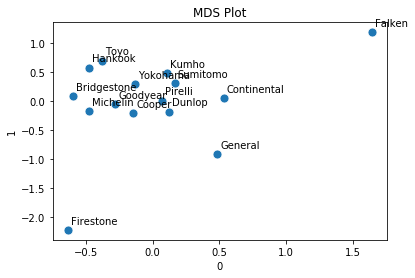

In [27]:
sns.scatterplot(mds_coordinates[0], mds_coordinates[1], s=80)
plt.title("MDS Plot")

brands = []
for i in disimilarity_matrix:
    brands.append(i)

# https://stackoverflow.com/questions/5147112/how-to-put-individual-tags-for-a-scatter-plot
for brand, x, y in zip(brands, mds_coordinates[0], mds_coordinates[1]):
    plt.annotate(
        brand.title(),
        xy=(x, y), xytext=(3, 4),
        textcoords='offset points', ha='left', va='bottom',
    )
plt.show()

### TASK B: Insights 

#### To Firestone:

As the 5th most talked about tire company, you are in a unique position. The four companies ahead of you are ahead by a significant margin. In fact, you're rarely in the same conversation as them. You have two strategies for moving forward. 1) You can compete with the three market leaders ahead of you and try to understand what is generating their success. Or 2) identify what makes you unique and understand which conversations you are in. If you are in a different conversations (perhaps drivers that are hyper concerned about safety) then maybe you should focus on that compentency and seperate yourself from the pack

#### To Michelin:

You are the most talked about tire brand, easily outpacing the competition. However, when according to our research, your brand is most similar to Bridgestone and Goodyear, the second and biggest in the market. You need to evaluate the services and core compentencies of yourself and those two competitors to ensure that the when customers compare you to them, they will choose you. If you stagnate then those two competitors will be the first to siphon your sales.

### Task C: 5 most frequent attributes and relationship with top 5 brands

In [28]:
ranked_cnt = []
for i in cnt:
    if i not in stopwords_set and i not in characterstoclean and i != '.' and i != '...' :
        ranked_cnt.append( (cnt[i], i) )
ranked_cnt.sort(reverse=True)

for i in range(len(ranked_cnt[:150])):
    print(str(i+1) + ") '" + str(ranked_cnt[i][1]) + "' appeared " + str(ranked_cnt[i][0]) + ' times')

1) 'tires' appeared 40848 times
2) 'tire' appeared 30322 times
3) 'car' appeared 17249 times
4) 'would' appeared 15484 times
5) 'get' appeared 11829 times
6) 'new' appeared 11045 times
7) 'one' appeared 10481 times
8) 'like' appeared 10443 times
9) 'good' appeared 9358 times
10) 'miles' appeared 9345 times
11) 'dont' appeared 7953 times
12) 'im' appeared 7317 times
13) 'wheels' appeared 7222 times
14) 'also' appeared 7089 times
15) 'dealer' appeared 6774 times
16) 'know' appeared 6563 times
17) 'wheel' appeared 6435 times
18) 'think' appeared 6399 times
19) 'snow' appeared 6349 times
20) 'much' appeared 6252 times
21) 'problem' appeared 6205 times
22) 'better' appeared 6088 times
23) 'go' appeared 5868 times
24) 'time' appeared 5714 times
25) 'well' appeared 5624 times
26) 'back' appeared 5425 times
27) 'set' appeared 5268 times
28) 'even' appeared 5194 times
29) 'could' appeared 5004 times
30) 'put' appeared 4961 times
31) 'need' appeared 4853 times
32) 'front' appeared 4802 times
33)

<pre>
Top 5 frequent attributes:
    wear, years, replace(s) -> durability
    problem(s), issue(s)    -> issues
    dealer, service         -> dealer interactions
    snow, winter            -> weather performance, particularly in snow
    price, cost             -> price
</pre>

In [29]:
attributes = {
    'durability': dict(),
    'issues': dict(),
    'dealer': dict(),
    'weather': dict(),
    'price': dict()
             }

In [30]:
for i in commentsdict:
    for j in word_tokenize(commentsdict[i]):
        if j == 'wears' or j == 'wear' or j == 'years' or j == 'year' or j == 'replaces' or j == 'replace':
            attributes['durability'][i] = commentsdict[i]
        elif j == 'problems' or j == 'problem' or j == 'issue' or j == 'issues':
            attributes['issues'][i] = commentsdict[i]
        elif j == 'dealers' or j == 'dealer' or j == 'service' or j == 'services':
            attributes['dealer'][i] = commentsdict[i]
        elif j == 'snow' or j == 'snows' or j == 'winter':
            attributes['weather'][i] = commentsdict[i]
        elif j == 'price' or j == 'costs' or j == 'cost':
            attributes['price'][i] = commentsdict[i]

In [31]:
attributes['price']

{'comment2': 'i purchased a new 2001 sebring lxi convertible . im really happy with it . im considering buying the wind screen accessory that cost about 215. id like to get some feedback from anyone that might have one . does it really block the wind id appreciate any positive or negative comments .',
 'comment9': 'hi alli got a chance to buy a sebring2000lxi in very nice condwith very low miles25000 for a great price ~ but i live in the northeast mainewhere driving conditions can prove to be somewhat stressfull in the winter which is most of the year how does the car handle on snowy i wont say iceycause no vehicle handles well on ice conditionsany input or feedback on this topic would be helpful as i love the vehiclebut it wont do me any good if it cant handle winter conditions . thnx steve',
 'comment36': 'ok ok ... so i asked for the battery wisecrack with my signature ... .. i knew a fob was the chain for pocket watches ... .but times change and new meanings sprout up everywhere . 

In [32]:
top5brands = [i[0] for i in brand_mention_list[:5]]
top5brands

['michelin', 'bridgestone', 'goodyear', 'dunlop', 'firestone']

In [33]:
both_count = dict()
for brand in top5brands:
    both_count[brand] = dict()
    for attribute in attributes:
        num_comments_that_mention_both = 0
        for comment in attributes[attribute]:
            for word in word_tokenize(attributes[attribute][comment]):
                if word == brand:
                    num_comments_that_mention_both += 1
                    break
        both_count[brand][attribute] = num_comments_that_mention_both

In [34]:
# lift value - number of comments mention attribute, number of comments mention brand, and number of comments that mention both
brand_attribute_lift = dict()
for attribute in attributes:
    brand_attribute_lift[attribute] = dict()
    for brand in top5brands:
        brand_attribute_lift[attribute][brand] = both_count[brand][attribute]/(len(attributes[attribute].keys()) * brand_mention_dict[brand]) * len(commentsdict)


In [35]:
brand_attribute_lift

{'durability': {'michelin': 1.632980513694561,
  'bridgestone': 1.5544311798298978,
  'goodyear': 1.5448404334463004,
  'dunlop': 1.4694567015601863,
  'firestone': 1.5691736104628227},
 'issues': {'michelin': 1.060519734767305,
  'bridgestone': 1.1071711507638975,
  'goodyear': 1.207160863959334,
  'dunlop': 0.9265291428172141,
  'firestone': 1.2596567803285519},
 'dealer': {'michelin': 1.3663182506503317,
  'bridgestone': 1.3958115956769142,
  'goodyear': 1.2691819647282438,
  'dunlop': 0.9992525713935344,
  'firestone': 1.5808319456794115},
 'weather': {'michelin': 1.9688353355109454,
  'bridgestone': 2.1449743880471734,
  'goodyear': 2.116917637982022,
  'dunlop': 3.000732520605931,
  'firestone': 1.348182524152868},
 'price': {'michelin': 1.8324568239442673,
  'bridgestone': 1.5521697095753182,
  'goodyear': 1.6418353411940725,
  'dunlop': 1.7833886979427396,
  'firestone': 1.4613128442146635}}

In [36]:
brand_attribute_lift_list = []
for attribute in brand_attribute_lift:
    highest_brand_lift = 0
    highest_brand = ''
    for brand in brand_attribute_lift[attribute]:
        if brand_attribute_lift[attribute][brand] > highest_brand_lift:
            highest_brand_lift = brand_attribute_lift[attribute][brand]
            highest_brand = brand
    
    print('The highest lift value for ' + attribute.title() + ' was ' + str(round(highest_brand_lift,2)) + ' by ' + highest_brand.title())

The highest lift value for Durability was 1.63 by Michelin
The highest lift value for Issues was 1.26 by Firestone
The highest lift value for Dealer was 1.58 by Firestone
The highest lift value for Weather was 3.0 by Dunlop
The highest lift value for Price was 1.83 by Michelin


### TASK D: Product and Advertisement Recommendations

#### To Dunlop:
While Dunlop isn't a leader in the market, many customers associate Dunlop tires with quality performance in inclement, snowy weather. If Dunlop doesn't need to be a market leader to be successful - if anything, they should focus their products on handling the roughest conditions and advertise their tires' saftey and performance to advertise this to their customers. Essentially - "you don't want a Bridgestone doing a Dunlop's job."

#### To Michelin:
Michelin should take note that customers go to them for their durability and price. These are the qualities that make Michelin the most talked about brand. However, to protect this brand, they need to appeal to the masses - by making low-cost, high durability tires. Customers should walk into a the tire shop alread knowing that they will buy Michelin. As such, they need to market themselves as the bang-for-your-buck tire company. Doing the most for the least.

### Lift values between brands for each attribute (not required, but interesting)

In [37]:
cross_brand_attribute = dict()
for brand1 in top5brands:
    cross_brand_attribute[brand1] = dict()
    for brand2 in top5brands:
        cross_brand_attribute[brand1][brand2] = dict()
        for attribute in attributes:
            cross_brand_attribute[brand1][brand2][attribute] = dict()

In [ ]:
for brand1 in top5brands:
    for brand2 in top5brands:
        for attribute in attributes:
            for comment in attributes[attribute]:
                brand1_mention = 0
                brand2_mention = 0
                both_mention = 0
                
                for word in word_tokenize(attributes[attribute][comment]):
                    if brand1 == word:
                        brand1_mention = 1
                    if brand2 == word:
                        brand2_mention = 1
                    if brand1_mention == 1 and brand2_mention == 1:
                        both_mention = 1
                
                cross_brand_attribute[brand1][brand2][attribute][comment] = [brand1_mention, brand2_mention, both_mention]
                    

In [ ]:
brand_attributes_lift_values = dict()
for brand1 in top5brands:
    brand_attributes_lift_values[brand1] = dict()
    for brand2 in top5brands:
        brand_attributes_lift_values[brand1][brand2] = dict()
        for attribute in attributes:
            results = list(cross_brand_attribute[brand1][brand2][attribute].values())
            lift_value = list(map(lambda x: x[2]/(x[1]*x[0]) * len(cross_brand_attribute[brand1][brand2][attribute].keys()), [pd.DataFrame(results).sum()]))[0] 
            brand_attributes_lift_values[brand1][brand2][attribute] = lift_value

In [549]:
brand_attributes_lift_values['michelin']['bridgestone']

{'durability': 2.813831815914803,
 'issues': 3.2503555268261155,
 'dealer': 2.257495590828924,
 'weather': 2.3532498877413563,
 'price': 2.499636495819702}

## EXTRA

## Get all the comments that mention goodyear

In [11]:

goodyear_comments = {}
for i in commentsdict:
    if 'goodyear' in commentsdict[i]:
        goodyear_comments[i] = commentsdict[i]

In [12]:
len(goodyear_comments)

1381

## Get all the words used in comments that mention goodyear

In [13]:
words_in_goodyear_comments = []
for i in goodyear_comments:
    for j in word_tokenize(goodyear_comments[i]):
        words_in_goodyear_comments.append(j)

In [14]:
gdyr_cnt = Counter(words_in_goodyear_comments)

In [56]:
ranked_goyr_cnt = []
for i in gdyr_cnt:
    if i not in stopwords_set and i not in characterstoclean and i != '.' and i != '...' and i not in 'goodyears':
        ranked_goyr_cnt.append( (gdyr_cnt[i], i) )
ranked_goyr_cnt.sort(reverse=True)
ranked_goyr_cnt[:10]

[(2043, 'tires'),
 (1112, 'tire'),
 (516, 'miles'),
 (394, 'car'),
 (386, 'new'),
 (355, 'would'),
 (313, 'michelin'),
 (311, 'like'),
 (291, 'get'),
 (285, 'set')]

## Comments with goodyear and ____ in them

In [466]:
comparisonstring = 'wear'

comments_with_gdyr_and = []
for i in goodyear_comments:
    if comparisonstring in goodyear_comments[i]:
        comments_with_gdyr_and.append(goodyear_comments[i])
len(comments_with_gdyr_and)

203

In [26]:
comments_with_gdyr_and[0]

'hey thanks for your response . i did have them install 2 new goodyear tires to replace the 2 that i had just purchased and they are just as bad . the goodyears that i have are called american eagles . is that a private labled model maybe i would be better off going to a different walmart maybe they carry a different tire for my car . maybe they have technicians that are nice . maybe just maybe .'

Possibly filter lift value to represent associations within a maximum word count  
    Beto -- Healthcare (no more than 6 words in between)  
mds map a disimilarity matrix, not similarity matrix